TCAGAGCTCTAGAGTTGGTTCTGAGAGAGATCGGTTACTCGGAGGAGGCTGTGTCACTCATAGAAGGGATCAATCACACCCACCACGTGTACCGAAACAA
TCAGAGCTCTAGAGTTGGTTCCAGAGCTCTAGAGTTGGTTCTAGAGCTCTAGAGTTGGTTCTGGAGCTCTAGAGTTGGTTCTGAAGCTCTAGAGTTGGTTCTGAGGCTCTAGAGTTGGTTCTGAGACTCTAGAGTTGGTTCTGAGAGTCTAGAGTTGGTTCTGAGAGACTAGAGTTGGTTCTGAGAGAGTAGAGTTGGTTCTGAGAGAGAAGAGTTGGTTCTGAGAGAGATGAGTTGGTTCTGAGAGAGATCAGTTGGTTCTGAGAGAGATCGGTTGGTTCTGAGAGAGATCGGTTGGTTCTGAGAGAGATCGGTTGGTTCTGAGAGAGATCGGTTGGTTCTGAGAGAGATCGGTTAGTTCTGAGAGAGATCGGTTACTTCTGAGAGAGATCGGTTACTTCTGAGAGAGATCGGTTACTCCTGAGAGAGATCGGTTACTCGTGAGAGAGATCGGTTACTCGGGAGAGAGATCGGTTACTCGGAAGAGAGATCGGTTACTCGGAGGAGAGATCGGTTACTCGGAGGAGAGATCGGTTACTCGGAGGAGAGATCGGTTACTCGGAGGAGAGATCGGTTACTCGGAGGAGGGATCGGTTACTCGGAGGAGGCATCGGTTACTCGGAGGAGGCTTCGGTTACTCGGAGGAGGCTGCGGTTACTCGGAGGAGGCTGTGGTTACTCGGAGGAGGCTGTGGTTACTCGGAGGAGGCTGTGTTTACTCGGAGGAGGCTGTGTCTACTCGGAGGAGGCTGTGTCAACTCGGAGGAGGCTGTGTCACCTCGGAGGAGGCTGTGTCACTTCGGAGGAGGCTGTGTCACTCCGGAGGAGGCTGTGTCACTCAGGAGGAGGCTGTGTCACTCATGAGGAGGCTGTGTCACTCATAAGGAGGCTGTGTCACTC

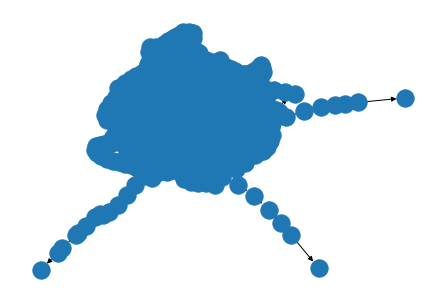

In [18]:
import networkx as nx
import matplotlib as plt
import scipy
import os
import statistics
import argparse
#taille_k=21

def read_fastq(fichier_fastq):
    with open(fichier_fastq,"r") as fastq:
        for line in enumerate(fastq):
            yield next(fastq)[:-1]
            next(fastq)
            next(fastq)
            


def cut_kmer(seq, taille_k):
    #On génère des k-mers de taille désirée à partir d'un read .
    for i in range(len(seq)-taille_k+1):
        yield seq[i:i+taille_k]
        
if __name__=="__main__" :
    for i in read_fastq("data\eva71_plus_perfect.fq."):
        print(i)
        for j in cut_kmer(i,taille_k):
            print(j,end='')
        break
        
def build_kmer_dict(fichier_fastq,taille_k):
    """Calcule des occurrences des Kmers dans les reads issus du fastq.
    """
    liste_reads = []
    for sequence in fichier_fastq:
        liste_reads.append(sequence)
    occurrence_kmers = {}
    for read in liste_reads:
        for kmer in cut_kmer(read, taille_k):
            if kmer in occurrence_kmers.keys():
                occurrence_kmers[kmer] += 1
            else:
                occurrence_kmers[kmer] = 1
    return occurrence_kmers



def build_graph(dict_kmers):
    """On créé un premier digraph en prenant en compte tout les kmers générés.
    """
    graph = nx.DiGraph()
    for kmer, poids in dict_kmers.items():
        graph.add_edge(kmer[:-1], kmer[1:], weight=poids)
    nx.draw(graph)
    return graph

#build_kmer_dict(read_fastq("data\eva71_two_reads.fq."), taille_kmer)
#graph=build_graph(build_kmer_dict(read_fastq("data\eva71_plus_perfect.fq."), taille_k))

def get_starting_nodes(graph):
    """Fonction permettant de définir les noeuds d'entrée."""
    noeuds_entree = []
    for noeud in graph.nodes:
        if len(list(graph.predecessors(noeud))) == 0:
            noeuds_entree.append(noeud)
    return noeuds_entree

noeuds_entree = get_starting_nodes(graph)
                                   
def get_sink_nodes(graph):
    """Fonction permettant de définir les noeuds de sortie."""
    noeuds_sortie = []
    for noeud in graph.nodes:
        if len(list(graph.successors(noeud))) == 0:
            noeuds_sortie.append(noeud)
    return noeuds_sortie
                                   
noeuds_sortie = get_sink_nodes(graph)
                                   
def get_contigs(graph, start, end):
    """Fonction permettant de générer une liste de tuples contenant les contigs avec leur taille.
    """
    contigs = []
    for noeud_depart in start:
        for noeud_fin in end:
            for path in nx.all_simple_paths(graph,source=noeud_depart, target=noeud_fin):
                prep_contig = path
                contig_ecrit = prep_contig[0]
                for i in range(1, len(prep_contig)):
                    contig_ecrit += prep_contig[i][-1:]
                contigs.append((contig_ecrit, len(contig_ecrit)))
    return contigs


def fill(text, width=80):
    """Split text with a line return to respect fasta format"""
    return os.linesep.join(text[i:i+width] for i in range(0, len(text), width))

def save_contigs(liste_contigs, nom_fichier):
    """Cette fonction permet de sauvegarder les contigs dans un fichier FASTA
    """
    with open(nom_fichier, "w") as fichier_sortie:
        numero = 0
        for contigs in liste_contigs:
            fichier_sortie.write(">contig_{0} len={1}\n".format(numero, contigs[1]))
            fichier_sortie.write("{0}\n".format(fill(contigs[0])))
            numero += 1

    

lg_fichier = "Contigs_" + str(len(get_contigs(graph,noeuds_entree,noeuds_sortie)))
save_contigs(get_contigs(graph,noeuds_entree,noeuds_sortie), lg_fichier)

def std(liste_valeurs):
    """Calcul l'écart-type de la liste de valeurs"""
    return statistics.stdev(liste_valeurs)


def path_average_weight(graph, chemin):
    """Cette fonction retourne le poids moyen d'un chemin
    """
    poids = 0
    nbre_edges = 0
    edges = graph.subgraph(chemin).edges(data=True)
    #On va récupérer les poids de chaque lien.
    for u_value, v_value, e_value in edges:
        poids += e_value['weight']
        nbre_edges += 1
    poids = poids/nbre_edges
    return poids

def remove_paths(graph, liste_chemins, delete_entry_node=False, delete_sink_node=False):
    """Fonction permettant de verifier si on enlève ou non les noeuds de départe et de fin pour chaque chemin
    Et retourne un graph nettoyé des chemins indésirables
    """
    for chemin in liste_chemins:
        if delete_entry_node == False and delete_sink_node == False:
            for noeud in chemin[1:-1]:
                if noeud in graph.nodes:
                    graph.remove_node(noeud)
        elif delete_entry_node and delete_sink_node == False:
            for noeud in chemin[:-1]:
                if noeud in graph.nodes:
                    graph.remove_node(noeud)
        elif delete_entry_node == False and delete_sink_node:
            for noeud in chemin[1:]:
                if noeud in graph.nodes:
                    graph.remove_node(noeud)
        elif delete_entry_node and delete_sink_node:
            for noeud in chemin[:]:
                if noeud in graph.nodes:
                    graph.remove_node(noeud)
    return graph

def select_best_path(graph, ensemble_chemins, ensemble_longueurs,poids_moyen, delete_entry_node=False, delete_sink_node=False):
    """Fonction qui va permettre d'identifier le meilleur chemin selon 3 critères :
    - poids le plus élevé
    - les chemins les plus long
    - on tire une au hasard
    Les chemins non conservés sont envoyés à la fonction remove_paths.
    """
    a_retirer = []
    taille_max = max(poids_moyen)
    chemin_fort_poids = []
    #On recherche les chemins qui ont un poids correspondant
    #au poids maximum (de préférence un seul ...)
    for i in range(len(ensemble_chemins)):
        if poids_moyen[i] == taille_max:
            chemin_fort_poids.append(ensemble_chemins[i])
    #On récupère les chemins à conserver puis on ajoute
    #les autres à la liste "a_retirer"
    for chemin in chemin_fort_poids:
        ensemble_chemins.remove(chemin)
    a_retirer = ensemble_chemins + a_retirer
    #S'il y a plus qu'un chemin qui a le poids maximum on regarde
    #la taille de ceux le poids maximum.
    if len(chemin_fort_poids) > 1:
        longueur_max = max(ensemble_longueurs)
        grands_chemins = []
        for i in range(len(chemin_fort_poids)):
            if ensemble_longueurs[i] == longueur_max:
                grands_chemins.append(chemin_fort_poids[i])
        #On récupère les chemins à conserver puis on ajoute
        #les autres à la liste "a_retirer"
        for chemin in grands_chemins:
            chemin_fort_poids.remove(chemin)
        a_retirer = chemin_fort_poids + a_retirer
        #S'il y a plusieurs chemins qui ont la taille maximum
        #on tire un chemin au hasard parmis ceux ayant le poids
        #maximum et la plus grande taille.
        if len(grands_chemins) > 1:
            random.seed(9001)
            choix = random.randint(0, len(grands_chemins))
            print(choix)
            choix_chemin = grands_chemins[choix]
            #On récupère les chemins à conserver puis on ajoute
            #les autres à la liste "a_retirer"
            grands_chemins.remove(choix_chemin[0])
            a_retirer = grands_chemins + a_retirer
    #On enlève tous les chemins qui ont été ajoutés à la liste "a_retirer"
    graph = remove_paths(graph, a_retirer, delete_entry_node, delete_sink_node)
    return graph

def find_bubbles(graph):
    """Fonction qui va permettre de trouver les bulles au sein
    de l'arbre. Elle retournera les origines et les fins de ces
    bulles.
    """
    bulles = []
    ensemble_noeuds = list(graph.nodes)
    for i in range(len(ensemble_noeuds)):
    #On recherche si un noeud a plusieurs successeurs.
        if len(list(graph.successors(ensemble_noeuds[i]))) > 1:
            debut = ensemble_noeuds[i]
            #print("le noeud est:{}".format(ensemble_noeuds[i]))
            j = 1
            fin = ""
            #Si oui, on recherche le prochain noeud qui a plusieurs
            #prédécesseurs.
            #Tant qu'il n'y a qu'un predecesseur et que j est plus petit
            #que le nombre de noeuds "restants" on test si un noeud a plus
            #d'un predecesseur; ce qui permettrait d'encadrer la bulle
            fin_trouvee = False
            while fin_trouvee == False and j < (len(ensemble_noeuds)-i):
                if len(list(graph.predecessors(ensemble_noeuds[i+j]))) > 1:
                    #print(j)
                    fin = ensemble_noeuds[i+j]
                    #print(fin)
                    fin_trouvee = True
                j += 1
            #Si on a récupéré un noeud qui a des successeurs et un noeud
            #qui a des prédécesseurs on récupère les coordonnées.
            if fin != "":
                bulles.append([debut, fin])
    print(bulles)
    #On retourne les coordonnées qui encadrent les bulles.
    return bulles



def solve_bubble(graph, debut, fin):
    """Fonction permettant de nettoyer le graph, 
    en prenant un noeud ancêtre et un noeud descendant.
    """
    ensemble_chemins = []
    for path in nx.all_simple_paths(graph,    source=debut, target=fin):
        ensemble_chemins.append(path)
    print(ensemble_chemins)
    if len(ensemble_chemins) >= 2 and type(ensemble_chemins[1]) is list:
        poids_moyen = []
        ensemble_longueurs = []
        for chemin in ensemble_chemins:
            poids_moyen.append(path_average_weight(graph, chemin))
            ensemble_longueurs.append(len(chemin))
        print(poids_moyen)
        graph = select_best_path(graph, ensemble_chemins,ensemble_longueurs, poids_moyen, delete_entry_node=False, delete_sink_node=False)
    return graph

def simplify_bubbles(graph):
    """Fonction permettant de nettoyer le graph en détectant tous les chemins possible 
    entre un noeud ancêtre et un noeud descendant.
    """
    liste_bulles = find_bubbles(graph)
    for bulle in liste_bulles:
        if bulle[0] in graph.nodes and bulle[1] in graph.nodes:
            graph = solve_bubble(graph, bulle[0], bulle[1])

    return graph



def solve_entry_tips(graph, entrees):
    """Fonction qui permet d'enlever les entrées indésirables."""
    print(entrees)
    bornes_initiales = []
    #On cherche les noeuds avec des intersections en partant du début
    for noeuds_entree in entrees:
        ensemble_noeuds = list(graph.nodes)
        fin = ""
        for i in range(len(ensemble_noeuds)):
            if len(list(graph.predecessors(ensemble_noeuds[i]))) > 1:
                fin = ensemble_noeuds[i]
        if fin != "":
            bornes_initiales.append([noeuds_entree, fin])
    print(bornes_initiales)
    #Définitions des chemins et valeurs associées
    ensemble_chemins = []
    poids_moyen = []
    ensemble_longueurs = []
    for borne in bornes_initiales:
        for path in nx.all_simple_paths(graph,\
                source=borne[0], target=borne[1]):
            ensemble_chemins.append(path)
            poids_moyen.append(path_average_weight(graph, path))
            ensemble_longueurs.append(len(path))
    #Nettoyage du graph
    graph = select_best_path(graph, ensemble_chemins,\
    ensemble_longueurs, poids_moyen, delete_entry_node=True,\
    delete_sink_node=False)
    return graph

def solve_out_tips(graph, sorties):
    """Fonction qui permet d'enlever les entrées indésirables"""
    #établissement des bornes de chemins de sortie.
    bornes_initiales = []
    for noeuds_sortie in sorties:
        ensemble_noeuds = list(graph.nodes)
        debut = ""
        for i in range(len(ensemble_noeuds)):
            if len(list(graph.successors(ensemble_noeuds[i]))) > 1:
                debut = ensemble_noeuds[i]
        if debut != "":
            bornes_initiales.append([debut, noeuds_sortie])
    #Définitions des chemins et valeurs associées
    ensemble_chemins = []
    poids_moyen = []
    ensemble_longueurs = []
    for borne in bornes_initiales:
        for path in nx.all_simple_paths(graph,\
                source=borne[0], target=borne[1]):
            ensemble_chemins.append(path)
            poids_moyen.append(path_average_weight(graph, path))
            ensemble_longueurs.append(len(path))
    #Nettoyage du graph
    graph = select_best_path(graph, ensemble_chemins,\
    ensemble_longueurs, poids_moyen, delete_entry_node=False,\
    delete_sink_node=True)
    return graph

def main() :    
    fichier_fastq = read_fastq("data\eva71_plus_perfect.fq.")
    taille_k=21


    liste_reads = []
    for sequence in fichier_fastq:
        liste_reads.append(sequence)
    #print (liste_reads)

    liste_kmers = []
    for read in liste_reads:
        for kmers in cut_kmer(read, taille_k):
            liste_kmers.append(kmers)
    #print(liste_kmers)
    occurrence_kmers = build_kmer_dict(fichier_fastq, taille_k)
    #print(occurrence_kmers)



    debuts = get_starting_nodes(graph)
    fins = get_sink_nodes(graph)
    liste_contigs = get_contigs(graph, debuts, fins)

    graph = simplify_bubbles(graph)
    noeuds_entree = get_starting_nodes(graph)
    while len(noeuds_entree) > 1:
        graph = solve_entry_tips(graph, noeuds_entree)
        noeuds_entree = get_starting_nodes(graph)
    noeuds_entree = get_starting_nodes(graph)

    noeuds_terminaux = get_sink_nodes(graph)
    while len(noeuds_terminaux) > 1:
        graph = solve_out_tips(graph, noeuds_terminaux)
        noeuds_terminaux = get_sink_nodes(graph)
    noeuds_terminaux = get_sink_nodes(graph)

    graph = simplify_bubbles(graph)

    final_contig = get_contigs(graph, noeuds_entree, noeuds_terminaux)
    print("\n\n\nOn obtient {} noeuds d'entrée.".format(len(noeuds_entree)))
    print("On obtient {} noeuds de sortie.".format(len(noeuds_terminaux)))
    print("Ce qui nous donne {} contigs généré(s).".format(len(final_contig))) 

    print(final_contig)
    nx.draw(graph)
    save_contigs(final_contig, "Final.fna")
    
if __name__ == "__main__":
    main()